# MLP with image augmentation

<ol>1. Loading the dataset</ol>
<ol>2. Pre-processing the data</ol>
<ol>3. Creating training and validation set</ol>
<ol>4. Defining the model architecture</ol>
<ol>5. Compiling the model</ol>
<ol>6. Training the model</ol>
<ol>7. Evaluating model performance</ol>

In [1]:
import tensorflow as tf
import keras
print('tensorflow version: ', tf.__version__)
print('keras version: ', keras.__version__)

tensorflow version:  2.9.2
keras version:  2.9.0


In [2]:
# define sess to use gpu
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P4000, pci bus id: 0000:00:05.0, compute capability: 6.1



In [3]:
# import necessary libraries and functions
import os
import joblib
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Dense, InputLayer
from keras.models import Sequential

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

In [4]:
import sys

sys.path.append('..')
from utils.s3_class import S3Functions
s3_funcs = S3Functions(bucket_name='jdgallegoq-pinacle')

In [5]:
# create random number generator
seed = 42
rng = np.random.RandomState(seed)

In [6]:
# train data
train_data = pd.read_csv(s3_funcs.read_object(key='gender_clf/train/train.csv'))
print(train_data.info())

# test data
test_data = pd.read_csv(s3_funcs.read_object(key='gender_clf/test.csv'))
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12196 entries, 0 to 12195
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  12196 non-null  object
 1   class        12196 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 190.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5227 entries, 0 to 5226
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_names  5227 non-null   object
dtypes: object(1)
memory usage: 41.0+ KB
None


In [7]:
train_data['class'].value_counts()

1    6174
0    6022
Name: class, dtype: int64

In [8]:
# load images
IMAGES_PATH = 'gender_clf/train/images/'

X = []
not_found = []
num_images_read = 5000
#for img_name in tqdm(train_data.image_names):
for img_name in tqdm(train_data.image_names[:num_images_read]):
  img = s3_funcs.read_image(key=IMAGES_PATH+img_name)
  X.append(img)

X = np.array(X)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [9]:
X.shape

(5000, 224, 224, 3)

In [10]:
# preprocessing
# converting into 1-d array cause MLP works with 1-d arrays
X = X.reshape(X.shape[0], 224*224*3)
X.shape

(5000, 150528)

In [11]:
X.min(), X.max()

(0, 255)

In [12]:
# normalizar pixeles
X = X / X.max()

X.min(), X.max()

(0.0, 1.0)

In [13]:
# split dataset
y = train_data['class'].values[:num_images_read]
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

In [14]:
# Model architecture
#from tensorflow.keras.preprocessing.image import ImageGenerator
from keras.layers import (
    InputLayer,
    Dense,
    Dropout,
    BatchNormalization,
    Flatten
    )
from keras.initializers import glorot_normal
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint
    )
from keras.models import Sequential
from keras.optimizers import Adam

In [16]:
#image_augmentation = ImageGenerator(
#    rotation_image=45,
#    width_shift_range=40,
#    height_shift_range=40,
#    horizontal_flip=True,
#    vertical_flip=True,
#    fill_mode='nearest'
#)
#image_augmentation.fit(X_train)

In [20]:
model = Sequential()
model.add(InputLayer(input_shape=X_train.shape[1]))
model.add(Flatten())
model.add(Dense(units=100, activation='relu', kernel_initializer=glorot_normal(seed=seed)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(units=100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_3 (Dense)             (None, 100)               15052900  


                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_3 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total para

In [17]:
# define earlystopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    mode='min'
)
# optimizer
adam = Adam(learning_rate=1e-5, clipvalue=1)

# model checkpointing
filepath = '../module/models/best_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='min')
callbacks_list = [early_stopping, checkpoint]

In [21]:
model.compile(
    loss='binary_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [22]:
model_history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    callbacks=callbacks_list
)

2024-04-10 23:30:53.477389: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.
2024-04-10 23:30:56.293132: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2408448000 exceeds 10% of free system memory.


Epoch 1/50
125/125 [==============================] - 9s 45ms/step - loss: 0.8155 - accuracy: 0.6135 - val_loss: 0.5942 - val_accuracy: 0.7040
Epoch 2/50
125/125 [==============================] - 4s 29ms/step - loss: 0.7357 - accuracy: 0.6400 - val_loss: 0.5836 - val_accuracy: 0.7350
Epoch 3/50
125/125 [==============================] - 3s 27ms/step - loss: 0.7208 - accuracy: 0.6478 - val_loss: 0.5726 - val_accuracy: 0.7260
Epoch 4/50
125/125 [==============================] - 3s 27ms/step - loss: 0.7090 - accuracy: 0.6503 - val_loss: 0.5312 - val_accuracy: 0.7420
Epoch 5/50
125/125 [==============================] - 4s 29ms/step - loss: 0.6873 - accuracy: 0.6710 - val_loss: 0.6090 - val_accuracy: 0.6680
Epoch 6/50
125/125 [==============================] - 4s 29ms/step - loss: 0.6879 - accuracy: 0.6587 - val_loss: 0.5325 - val_accuracy: 0.7430
Epoch 7/50
125/125 [==============================] - 4s 29ms/step - loss: 0.6882 - accuracy: 0.6680 - val_loss: 0.5773 - val_accuracy: 0.7280

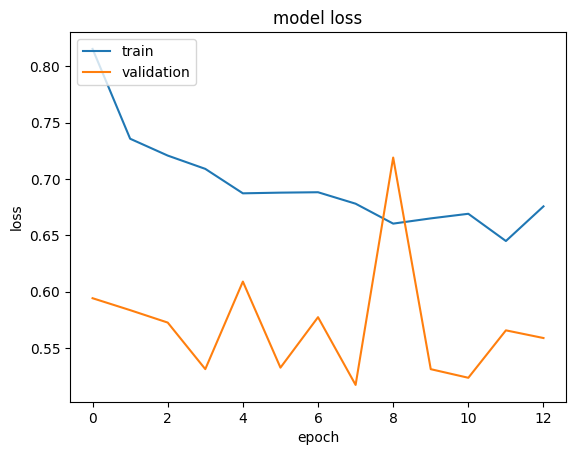

In [23]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc='upper left')
plt.show()